# Rede neural convolucional para classificação binária de imagens (loader)

In [1]:
import pandas as pd
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
test_path = 'dataset1/test'

Carregamento do modelo pré-treinado

In [3]:
model = load_model('model.33-0.14.hdf5')

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
__________

Carregamento das imagens de teste

In [5]:
test_datagen = ImageDataGenerator(rescale = 1./225)
test_generator = test_datagen.flow_from_directory('dataset1/test',
                                                 target_size = (150,150),
                                                 batch_size = 1,
                                                    shuffle=False)

Found 500 images belonging to 1 classes.


Reset do gerador de testes e predição

In [6]:
test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1)

500/500 [==============================] - 10s 19ms/step


In [7]:
concl = np.empty([len(pred)],  dtype=object)
real = np.empty([len(pred)],  dtype=object)
for i in range(len(pred)) :
    if(pred[i] > 0.5):
        concl[i] = 'Infectado'
    else:
        concl[i] = 'Desinfectado'
        
for i in range(len(pred)):
    if(i <= (len(pred)/2)-1):                    #Caso seja par o número de amostras, se ímpar, aterar aqui
        real[i] = 'Desinfectado'
    else:
        real[i] = 'Infectado'

Gera arquivo do Excel com conclusões

In [8]:
filenames=test_generator.filenames
for k in range(len(filenames)):
    filenames[k] = filenames[k].replace('test_folder\\', '')

In [9]:
results=pd.DataFrame({"Nome do arquivo":filenames,
                      "Conclusão":concl})
results.to_excel("resultados.xlsx",index=False, encoding='utf-8')

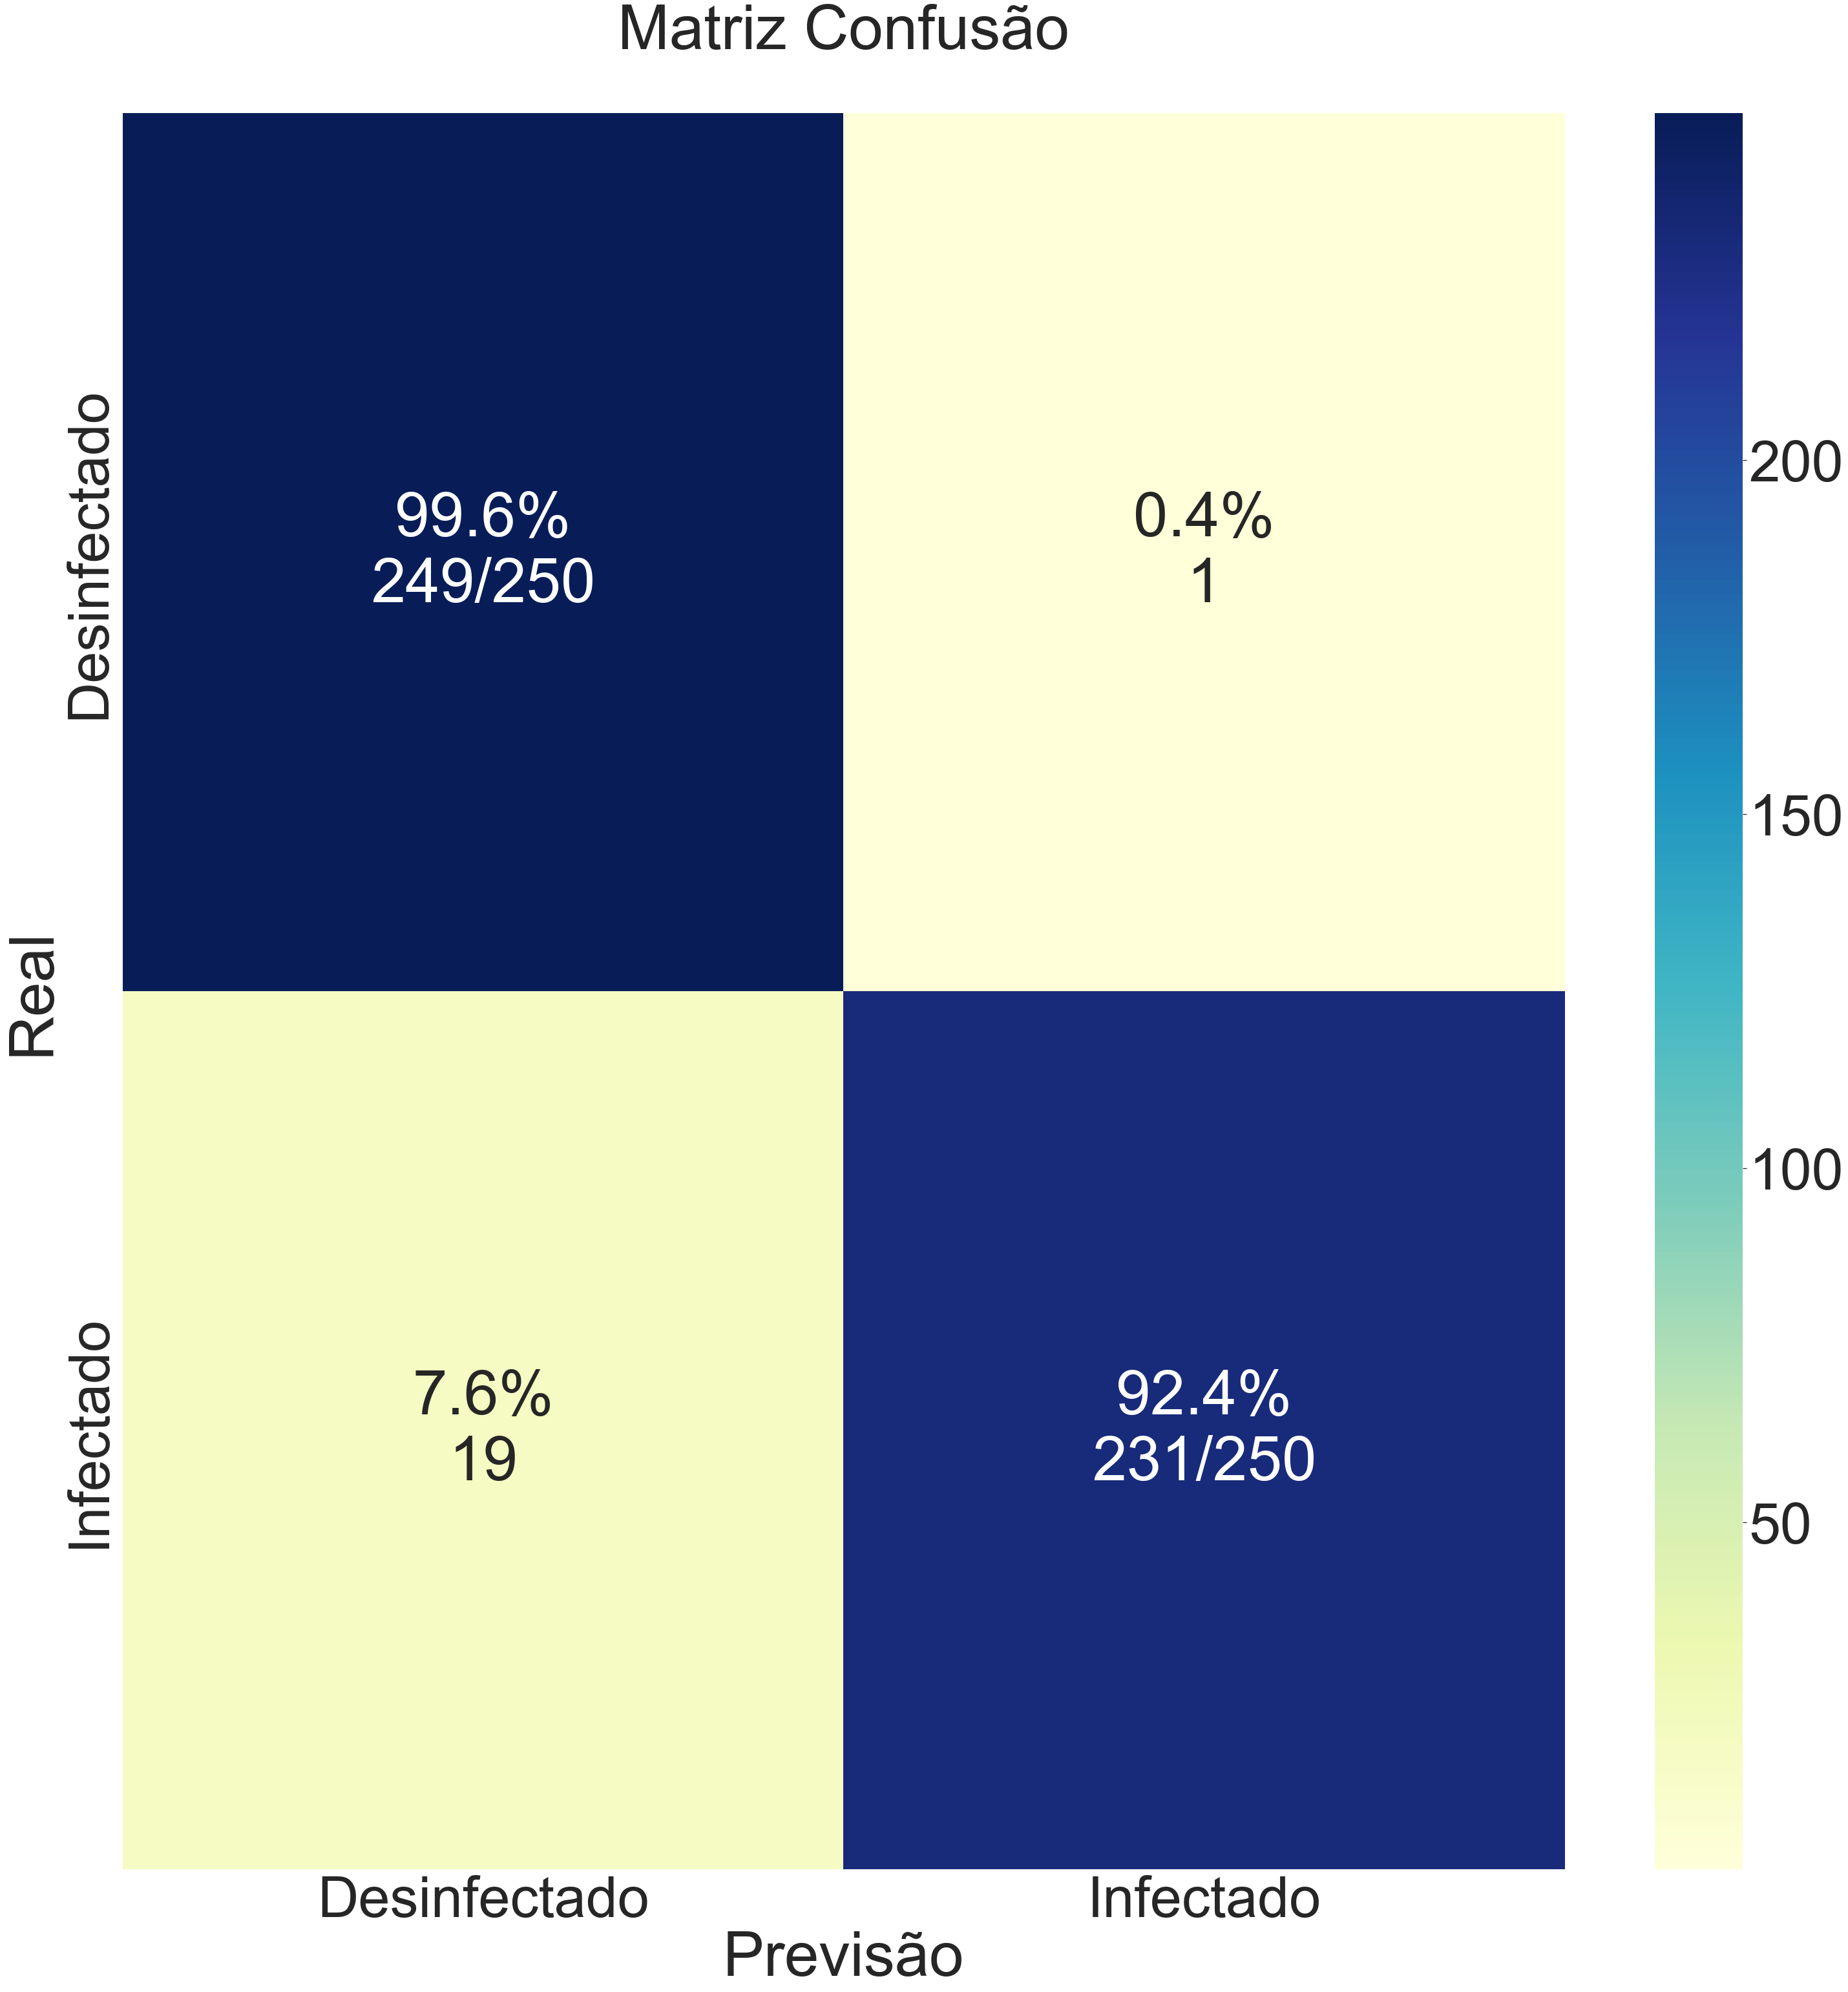

In [12]:
def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(50,50)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Real'
    cm.columns.name = 'Previsão'
    sns.set(font_scale=8)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap="YlGnBu")
    ax.set_title('Matriz Confusão', pad = 100)
    ax.yaxis.set_ticklabels(labels, va = 'center')
    plt.savefig(filename)
    
cm_analysis(real, concl, 'confusao.png', ['Desinfectado','Infectado'])